In [1]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlflow.tracking import MlflowClient

In [2]:
mlflow.set_tracking_uri("file:///cephfs/home/ledneva/Work/hw_mlops_itmo_2025/mlruns")
client = MlflowClient()

TARGET_EXPERIMENTS = ["eval_catboost", "eval_rf", "eval_lgbm"]
DATASETS = ["enhancers", "promoter_all", "splice_sites_all", "H3K9me3", "H4K20me1"]

experiments = client.search_experiments()
results = []
for exp_name in TARGET_EXPERIMENTS:
    print(exp_name)
    exp = client.get_experiment_by_name(exp_name)
        
    runs = client.search_runs(exp.experiment_id)
    for run in runs:
        params = run.data.params
        metrics = run.data.metrics
        
        if params.get('dataset') not in DATASETS:
            continue
            
        results.append({
            'dataset': params['dataset'],
            'model': params['model'],
            'metric_type': params['metric'],
            'metric_value': metrics[params['metric']],
            'experiment': exp_name
        })

df = pd.DataFrame(results)

eval_catboost
eval_rf
eval_lgbm


In [3]:
df

,dataset,model,metric_type,metric_value,experiment
0,H4K20me1,catboost,MCC,0.582338,eval_catboost
1,H3K9me3,catboost,MCC,0.270636,eval_catboost
2,splice_sites_all,catboost,Accuracy,0.343000,eval_catboost
3,promoter_all,catboost,F1,0.853129,eval_catboost
4,enhancers,catboost,MCC,0.478912,eval_catboost
5,H4K20me1,random_forest,MCC,0.509463,eval_rf
6,H3K9me3,random_forest,MCC,0.224969,eval_rf
7,splice_sites_all,random_forest,Accuracy,0.510667,eval_rf
8,promoter_all,random_forest,F1,0.839871,eval_rf
9,enhancers,random_forest,MCC,0.429639,eval_rf


In [4]:
from IPython.display import display, Image

best_models_summary = (
    df.loc[df.groupby("dataset")["metric_value"].idxmax()]
    .sort_values("dataset")
    .rename(columns={"model": "best_model", "metric_value": "best_metric"})
)
best_models_summary = best_models_summary[["dataset", "best_model", "best_metric", "metric_type"]]
best_models_summary.to_csv("MLflow_artifacts/best_models_summary.csv", index=False)

print("Лучшие модели по задачам:")
for _, row in best_models_summary.iterrows():
    print(
        f"{row['dataset']:<20} -> {row['best_model']:<12} "
        f"({row['metric_type']}: {row['best_metric']:.4f})"
    )

Лучшие модели по задачам:
H3K9me3              -> catboost     (MCC: 0.2706)
H4K20me1             -> catboost     (MCC: 0.5823)
enhancers            -> lightgbm     (MCC: 0.4818)
promoter_all         -> lightgbm     (F1: 0.8580)
splice_sites_all     -> lightgbm     (Accuracy: 0.5470)


In [5]:
from IPython.display import display, Image

worst_models_summary = (
    df.loc[df.groupby("dataset")["metric_value"].idxmin()]
    .sort_values("dataset")
    .rename(columns={"model": "worst_model", "metric_value": "worst_metric"})
)
worst_models_summary = worst_models_summary[["dataset", "worst_model", "worst_metric", "metric_type"]]
worst_models_summary.to_csv("MLflow_artifacts/worst_models_summary.csv", index=False)

print("Худшие модели по задачам:")
for _, row in worst_models_summary.iterrows():
    print(
        f"{row['dataset']:<20} -> {row['worst_model']:<12} "
        f"({row['metric_type']}: {row['worst_metric']:.4f})"
    )

Худшие модели по задачам:
H3K9me3              -> random_forest (MCC: 0.2250)
H4K20me1             -> random_forest (MCC: 0.5095)
enhancers            -> random_forest (MCC: 0.4296)
promoter_all         -> random_forest (F1: 0.8399)
splice_sites_all     -> catboost     (Accuracy: 0.3430)


In [6]:
ALL_MODELS = df['model'].unique()
model_wins = best_models_summary["best_model"].value_counts().reindex(ALL_MODELS, fill_value=0).reset_index()
model_wins.columns = ["model", "num_wins"]

top_model = model_wins.loc[model_wins["num_wins"].idxmax()]
print(f"Модель с наибольшим числом побед: {top_model['model']} ({top_model['num_wins']} задач)")

worst_model = model_wins.loc[model_wins["num_wins"].idxmin()]
print(f"Модель с наименьшим числом побед: {worst_model['model']} ({worst_model['num_wins']} задач)")

Модель с наибольшим числом побед: lightgbm (3 задач)
Модель с наименьшим числом побед: random_forest (0 задач)


In [7]:
print("Все результаты:")
display(df.sort_values(by=["dataset", "model"]))

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="dataset", y="metric_value", hue="model",
    order=DATASETS,
    edgecolor="black"
)
plt.title("Сравнение моделей по задачам")
plt.ylabel("Значение метрики")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("MLflow_artifacts/model_comparison.png")
plt.close()

Все результаты:


,dataset,model,metric_type,metric_value,experiment
1,H3K9me3,catboost,MCC,0.270636,eval_catboost
11,H3K9me3,lightgbm,MCC,0.257029,eval_lgbm
6,H3K9me3,random_forest,MCC,0.224969,eval_rf
0,H4K20me1,catboost,MCC,0.582338,eval_catboost
10,H4K20me1,lightgbm,MCC,0.579064,eval_lgbm
5,H4K20me1,random_forest,MCC,0.509463,eval_rf
4,enhancers,catboost,MCC,0.478912,eval_catboost
14,enhancers,lightgbm,MCC,0.481788,eval_lgbm
9,enhancers,random_forest,MCC,0.429639,eval_rf
3,promoter_all,catboost,F1,0.853129,eval_catboost


Визуализация сравнения моделей:


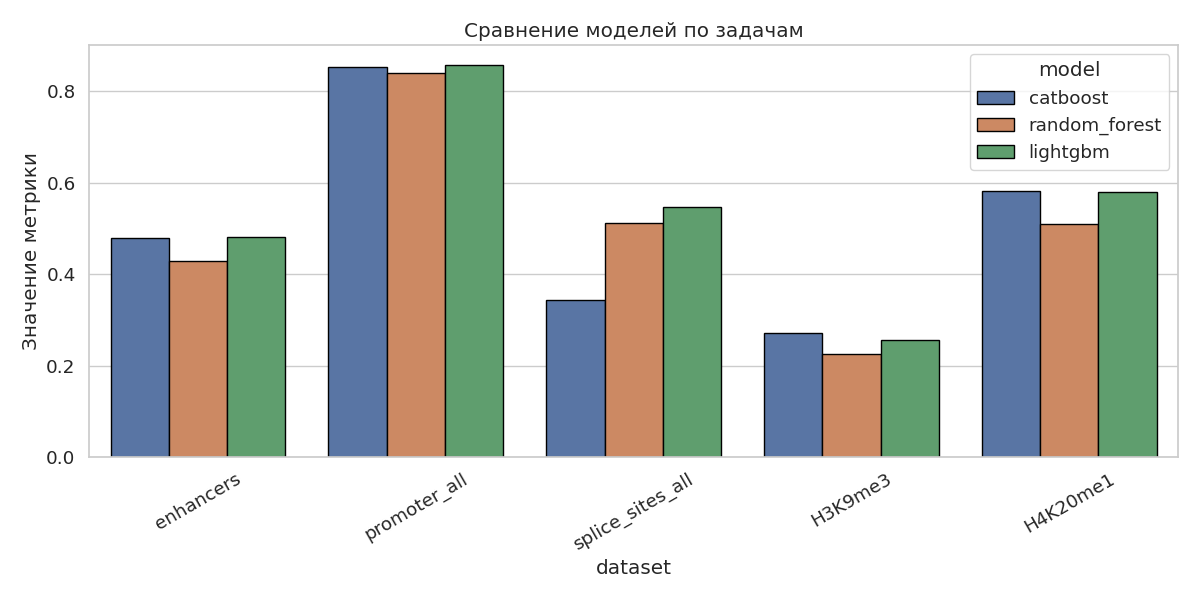

In [9]:
print("Визуализация сравнения моделей:")
display(Image(filename="MLflow_artifacts/model_comparison.png"))

In [10]:
with mlflow.start_run(run_name="Tracking-Based Analysis"):
    mlflow.set_tag("stage", "analysis")
    mlflow.log_artifact("MLflow_artifacts/best_models_summary.csv")
    mlflow.log_artifact("MLflow_artifacts/worst_models_summary.csv")
    mlflow.log_artifact("MLflow_artifacts/model_comparison.png")